In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib notebook
from matplotlib.colors import LogNorm
from matplotlib import rcParams

import pickle
import glob
from tqdm import tqdm


from ctapipe.coordinates import CameraFrame, HorizonFrame
from astropy.coordinates import SkyCoord

from ctapipe.visualization import CameraDisplay   # plot camera images
from ctapipe.io import event_source               # read rata
from ctapipe.calib import CameraCalibrator        # calibration from r0 to dl1
from ctapipe.calib.camera.gainselection import pick_gain_channel # gain selection
from ctapipe.image.cleaning import tailcuts_clean # image cleaning
from ctapipe.image import hillas_parameters       # parametrization
from traitlets.config import Config               # handeling of configurations
from ctapipe.io import EventSeeker

from diffuse_LUT_methods import *
from konsta_cta.reco import *
import astropy.units as u

In [3]:
def calc_angular_resolution(off_angle, trueE, q=0.68, erange=[0.01, 100], bins=10):
    '''
    off_angle - pd.Series
    true_e - pd.Series
    quantile - float
    erange - list, upper an lower edge in TeV
    ebins - int, number of bins
    '''

    ebins_log = np.linspace(np.log10(erange[0]), np.log10(erange[1]), bins+1)
    ebins = np.power(10, ebins_log)

    quantiles = np.zeros(shape=[2, bins])
    # loop over bins in energy
    for i in range(bins):

        angles_bin = off_angle.loc[(trueE >= ebins[i]) &\
                                   (trueE <= ebins[i+1])]
        N = len(angles_bin)

        quantiles[0, i] = angles_bin.quantile(q)
        # error of quantile follows binominal distribution
        quantiles[1, i] = np.sqrt(N * q * ( 1 - q)) / N

    # calculate mean positions 
    pos_log = np.mean(np.array([ebins_log[:-1], ebins_log[1:]]), axis=0)
    pos = np.power(10, pos_log)
    # get asymmetrical bin widths
    err = [pos - ebins[:-1], ebins[1:] - pos]

    return quantiles, pos, err

# Requirement

In [4]:
loge = [-1.64983, -1.49475, -1.32191, -1.05307, -0.522689, 
        0.139036, 0.949169, 1.67254,  2.20447, 2.49232]
e = np.power(10, loge)
angres = [0.453339 , 0.295111 , 0.203515 , 0.138619 , 0.0858772, 0.0569610, 0.0372988, 0.0274391, 0.0232297, 0.0216182]

In [5]:
output_dir = "/Users/konstantinpfrang/ctaout/"

In [6]:
def load_data(files):
    for file in tqdm(files, total=len(files)):
        try:
            datafile = pd.read_hdf(file, key="direction_reconstriction").iloc[:,[1,6]]
            data = pd.concat([data, datafile])
        except NameError:
            data = datafile
        except (HDF5ExtError, OSError):
            print("Not able to read {}".format(file))
            continue
    
    return data

# Diffuse reconstruction

In [8]:
datadir_diff_def = os.path.abspath("{}/diffuse/default".format(output_dir))
files = glob.glob("{}/output*gamma*".format(datadir_diff_def))

data_diff_def = load_data(files)

100%|██████████| 10000/10000 [28:59<00:00,  5.75it/s]


In [9]:
datadir_diff_LUT = os.path.abspath("{}/diffuse/onelist".format(output_dir))
files = glob.glob("{}/output*gamma*".format(datadir_diff_LUT))

data_diff_LUT = load_data(files)

100%|██████████| 10000/10000 [20:36<00:00,  8.09it/s]


In [10]:
datadir_diff_double = os.path.abspath("{}/diffuse/doublepass_corrected".format(output_dir))
files = glob.glob("{}/output*gamma*".format(datadir_diff_double))

data_diff_double = load_data(files)

100%|██████████| 10000/10000 [10:55<00:00, 15.25it/s]


/Users/konstantinpfrang/anaconda3/envs/cta-dev/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


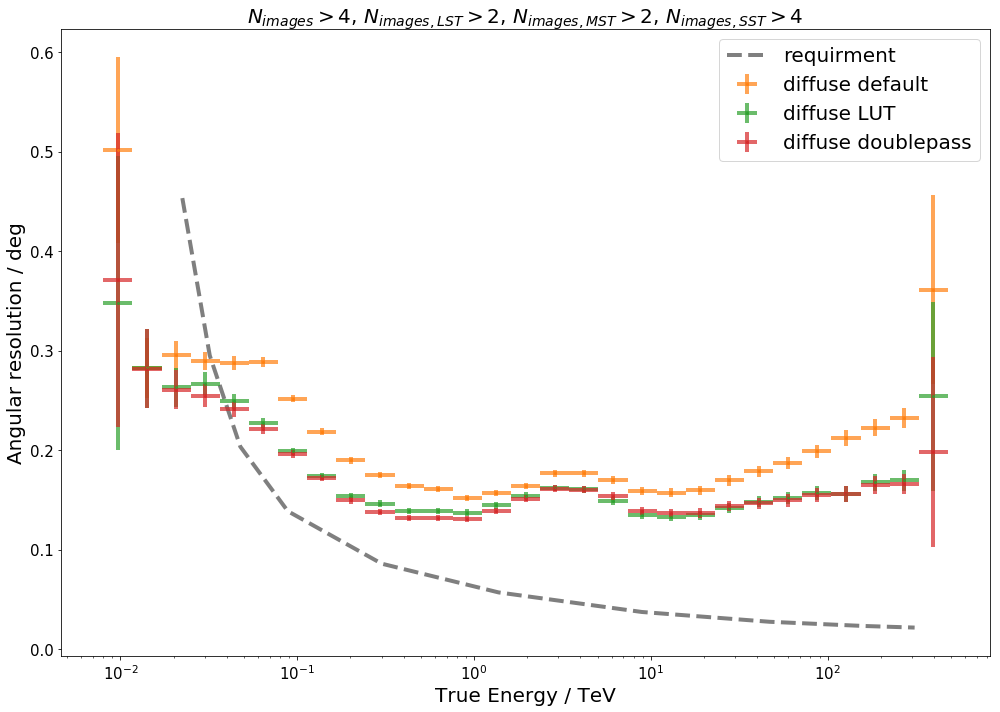

In [11]:
q_diff_def, pos, err_diff_def = calc_angular_resolution(off_angle=data_diff_def.off_angle,
                                  trueE=data_diff_def.MC_Energy, erange=[0.008, 700], bins=30)

q_diff_LUT, pos, err_diff_LUT = calc_angular_resolution(off_angle=data_diff_LUT.off_angle,
                                  trueE=data_diff_LUT.MC_Energy, erange=[0.008, 700], bins=30)

q_diff_double, pos, err_diff_double = calc_angular_resolution(off_angle=data_diff_double.off_angle,
                                  trueE=data_diff_double.MC_Energy, erange=[0.008, 700], bins=30)

plt.figure(figsize=(14,10))
rcParams['xtick.labelsize'] = 15
rcParams['ytick.labelsize'] = 15
plt.xscale('log')
#plt.yscale("log")
#plt.ylim([0,.5])
plt.errorbar(pos, q_diff_def[0], q_diff_def[1], err_diff_def, fmt="o", color="C1", zorder=10,
             label="diffuse default", linewidth=4, markersize=2, alpha=0.7)
plt.errorbar(pos, q_diff_LUT[0], q_diff_LUT[1], err_diff_LUT, fmt="o", color="C2", zorder=10,
             label="diffuse LUT", linewidth=4, markersize=2, alpha=0.7)
plt.errorbar(pos, q_diff_double[0], q_diff_double[1], err_diff_double, fmt="o", color="C3", zorder=10,
             label="diffuse doublepass", linewidth=4, markersize=2, alpha=0.7)

plt.plot(e, angres, linewidth=4, label="requirment", color="k", alpha=0.5, linestyle="--")
plt.xlabel("True Energy / TeV", fontsize=20)
plt.ylabel("Angular resolution / deg", fontsize=20)
plt.title(r"$N_{images}>4$, $N_{images, LST}>2$, $N_{images, MST}>2$, $N_{images, SST}>4$", fontsize=20)
plt.legend(fontsize=20)
plt.tight_layout()
plt.savefig("Angular_resolution_def_LUT_double.pdf")

In [3]:
output_dir = "/Users/konstantinpfrang/ctaout/point/"

# Cut in multiplicity

### Standard mutiplicity 5

### Multiplicity 4, comparison default weights with LUT weights

by default `weight = moments.intensity * (moments.length / moments.width)` is used.

In [5]:
max_files = None

#### Default weights, $N_{images} > 4$

In [12]:
datadir_default = os.path.abspath("{}/Multiplicity4/default_weights/".format(output_dir))

data_default = None
for file in glob.glob("{}/output*gamma*".format(datadir_default))[:max_files]:
    datafile = pd.read_hdf(file, key="direction_reconstriction")
    try:
        data_default = pd.concat([data_default, datafile])
    except NameError:
        data_default = datafile
    except (HDF5ExtError, OSError):
        print("Not able to read {}".format(file))
        continue

#### LUT weights, $N_{images} > 4$

In [13]:
datadir_LUT = os.path.abspath("{}/Multiplicity4/LUT_weights/".format(output_dir))

data_LUT = None
for file in glob.glob("{}/output*gamma*".format(datadir_LUT))[:max_files]:
    datafile = pd.read_hdf(file, key="direction_reconstriction")
    try:
        data_LUT = pd.concat([data_LUT, datafile])
    except NameError:
        data_LUT = datafile
    except (HDF5ExtError, OSError):
        print("Not able to read {}".format(file))
        continue

#### LUT weights, cut on ratio width / length, $N_{images} > 4$

In [14]:
datadir_LUT_ratiocut = os.path.abspath("{}/Multiplicity4/LUT_weights_ratiocut/".format(output_dir))

data_LUT_ratiocut = None
for file in glob.glob("{}/output*gamma*".format(datadir_LUT_ratiocut))[:max_files]:
    datafile = pd.read_hdf(file, key="direction_reconstriction")
    try:
        data_LUT_ratiocut = pd.concat([data_LUT_ratiocut, datafile])
    except NameError:
        data_LUT_ratiocut = datafile
    except (HDF5ExtError, OSError):
        print("Not able to read {}".format(file))
        continue

KeyError: 'No object named direction_reconstriction in the file'

#### LUT weights, cut on ratio width / length, $N_{images} > 4$, cut 2 per type and drop types

In [ ]:
datadir_LUT_ratiocut_pertype = os.path.abspath("{}/Multiplicity4_perType/LUT_weights_ratiocut_removedTypes_0801/".format(output_dir))

data_LUT_ratiocut_pertype = None
for file in glob.glob("{}/output*gamma*".format(datadir_LUT_ratiocut_pertype))[:max_files]:
    datafile = pd.read_hdf(file, key="direction_reconstriction")
    try:
        data_LUT_ratiocut_pertype = pd.concat([data_LUT_ratiocut_pertype, datafile])
    except NameError:
        data_LUT_ratiocut_pertype = datafile
    except (HDF5ExtError, OSError):
        print("Not able to read {}".format(file))
        continue

In [ ]:
quantiles_default, pos, err_default = calc_angular_resolution(off_angle=data_default.off_angle,
                                  trueE=data_default.MC_Energy, erange=[0.008, 700], bins=30)

quantiles_LUT, pos, err_LUT = calc_angular_resolution(off_angle=data_LUT.off_angle,
                                  trueE=data_LUT.MC_Energy, erange=[0.008, 700], bins=30)

quantiles_LUT_ratiocut, pos, err_LUT_ratiocut = calc_angular_resolution(off_angle=data_LUT_ratiocut.off_angle,
                                  trueE=data_LUT_ratiocut.MC_Energy, erange=[0.008, 700], bins=30)

quantiles_LUT_ratiocut_pertype, pos, err_LUT_ratiocut_pertype = calc_angular_resolution(off_angle=data_LUT_ratiocut_pertype.off_angle,
                                  trueE=data_LUT_ratiocut_pertype.MC_Energy, erange=[0.008, 700], bins=30)


plt.figure(figsize=(14,10))
rcParams['xtick.labelsize'] = 15
rcParams['ytick.labelsize'] = 15
plt.xscale('log')
#plt.ylim([0,.5])
plt.errorbar(pos, quantiles_default[0], quantiles_default[1], err_default, fmt="o", color="C1", zorder=10,
             label="default, multi 4", linewidth=4, markersize=2, alpha=0.7)
#plt.errorbar(pos, quantiles_LUT[0], quantiles_LUT[1], err_LUT, fmt="o", color="C0", zorder=10,
#             label="LUT, multi 4 ", linewidth=4, markersize=2, alpha=0.7)
plt.errorbar(pos, quantiles_LUT_ratiocut[0], quantiles_LUT_ratiocut[1], err_LUT_ratiocut, fmt="o", color="C2", zorder=10,
             label="LUT, multi 4, w/l cut", linewidth=4, markersize=2, alpha=0.6)
plt.errorbar(pos, quantiles_LUT_ratiocut_pertype[0], quantiles_LUT_ratiocut_pertype[1], err_LUT_ratiocut_pertype, fmt="o", color="C3", zorder=10,
             label="LUT, multi 4, per type 2 + remove, w/l cut", linewidth=4, markersize=2, alpha=0.6)

plt.plot(e, angres, linewidth=4, label="requirment", color="k", alpha=0.5, linestyle="--")
plt.xlabel("True Energy / TeV", fontsize=20)
plt.ylabel("Difference between\n true and reconstructed direction / deg", fontsize=20)

plt.legend(fontsize=20)
plt.tight_layout()
plt.savefig("Standardarray_default_vs_LUT.pdf")

# Comparison of different multiplicity cuts

In [ ]:
max_files = None

#### default weights, cut on ratio width / length, $N_{images} > 4$, cut per type 2 (SST 3) keep all if one passed

In [ ]:
datadir_def_keep = os.path.abspath("{}Multiplicity4_perType/defaultWeights_ratiocut_keepTypes_SST3_0801".format(output_dir))

data_def_keep = None
for file in glob.glob("{}/output*gamma*".format(datadir_def_keep))[:max_files]:
    datafile = pd.read_hdf(file, key="direction_reconstriction")
    try:
        data_def_keep = pd.concat([data_def_keep, datafile])
    except NameError:
        data_def_keep = datafile
    except (HDF5ExtError, OSError):
        print("Not able to read {}".format(file))
        continue

#### default weights, cut on ratio width / length, $N_{images} > 4$, cut per type 2 (SST 3) remove types

In [ ]:
datadir_def_remove = os.path.abspath("{}/Multiplicity4_perType/defaultWeights_ratiocut_removedTypes_SST3_0801".format(output_dir))

data_def_remove = None
for file in glob.glob("{}/output*gamma*".format(datadir_def_remove))[:max_files]:
    datafile = pd.read_hdf(file, key="direction_reconstriction")
    try:
        data_def_remove = pd.concat([data_def_remove, datafile])
    except NameError:
        data_def_remove = datafile
    except (HDF5ExtError, OSError):
        print("Not able to read {}".format(file))
        continue

#### LUT weights, cut on ratio width / length, $N_{images} > 4$, cut per type 2 (SST 3) keep all if one passed

In [ ]:
datadir_LUT_keep = os.path.abspath("{}Multiplicity4_perType/LUT_weights_ratiocut_keepTypes_SST3_0801".format(output_dir))

data_LUT_keep = None
for file in glob.glob("{}/output*gamma*".format(datadir_LUT_keep))[:max_files]:
    datafile = pd.read_hdf(file, key="direction_reconstriction")
    try:
        data_LUT_keep = pd.concat([data_LUT_keep, datafile])
    except NameError:
        data_LUT_keep = datafile
    except (HDF5ExtError, OSError):
        print("Not able to read {}".format(file))
        continue

#### LUT weights, cut on ratio width / length, $N_{images} > 4$, cut per type 2 (SST 3) remove types

In [ ]:
datadir_LUT_remove = os.path.abspath("{}Multiplicity4_perType/LUT_weights_ratiocut_removedTypes_SST3_0801".format(output_dir))

data_LUT_remove = None
for file in glob.glob("{}/output*gamma*".format(datadir_LUT_remove))[:max_files]:
    datafile = pd.read_hdf(file, key="direction_reconstriction")
    try:
        data_LUT_remove = pd.concat([data_LUT_remove, datafile])
    except NameError:
        data_LUT_remove = datafile
    except (HDF5ExtError, OSError):
        print("Not able to read {}".format(file))
        continue

In [ ]:
q_default_keep, pos, err_default_keep = calc_angular_resolution(off_angle=data_def_keep.off_angle,
                                  trueE=data_def_keep.MC_Energy, erange=[0.008, 700], bins=30)

q_default_remove, pos, err_default_remove = calc_angular_resolution(off_angle=data_def_remove.off_angle,
                                  trueE=data_def_remove.MC_Energy, erange=[0.008, 700], bins=30)

q_LUT_keep, pos, err_LUT_keep = calc_angular_resolution(off_angle=data_LUT_keep.off_angle,
                                  trueE=data_LUT_keep.MC_Energy, erange=[0.008, 700], bins=30)

q_LUT_remove, pos, err_LUT_remove = calc_angular_resolution(off_angle=data_LUT_remove.off_angle,
                                  trueE=data_LUT_remove.MC_Energy, erange=[0.008, 700], bins=30)


plt.figure(figsize=(14,10))
rcParams['xtick.labelsize'] = 15
rcParams['ytick.labelsize'] = 15
plt.xscale('log')
#plt.ylim([0,.5])
plt.errorbar(pos, q_default_keep[0], q_default_keep[1], err_default_keep, fmt="o", color="C1", zorder=10,
             label="default\n{:1.1e} events passed".format(len(data_def_keep)), linewidth=4, markersize=2, alpha=0.7)
#plt.errorbar(pos, q_default_remove[0], q_default_remove[1], err_default_remove, fmt="o", color="C0", zorder=10,
#             label="default weights remove types ", linewidth=4, markersize=2, alpha=0.7)
plt.errorbar(pos, q_LUT_keep[0], q_LUT_keep[1], err_LUT_keep, fmt="o", color="C2", zorder=10,
             label="LUT\n{:1.1e} events passed".format(len(data_LUT_keep)), linewidth=4, markersize=2, alpha=0.6)
plt.errorbar(pos, q_LUT_remove[0], q_LUT_remove[1], err_LUT_remove, fmt="o", color="C3", zorder=10,
             label="LUT, telescope types removed\n{:1.1e} events passed".format(len(data_LUT_remove)), linewidth=4, markersize=2, alpha=0.6)

plt.plot(e, angres, linewidth=4, label="requirment", color="k", alpha=0.5, linestyle="--")
plt.xlabel("True Energy / TeV", fontsize=20)
plt.ylabel("Angular resolution / deg", fontsize=20)
plt.title(r"$N_{images}>4$, $N_{images, LST}>2$, $N_{images, MST}>2$, $N_{images, SST}>3$", fontsize=20)
plt.legend(fontsize=20)
plt.tight_layout()
plt.savefig("Standardarray_def_LUT_removed_telescopes.pdf")

# Comparison of different multiplicity cuts SST4

In [5]:
max_files = None

#### default weights, cut on ratio width / length, $N_{images} > 4$, cut per type 2 (SST 4) keep all if one passed

In [6]:
datadir_def_keep = os.path.abspath("{}Multiplicity4_perType/SST4/default_keep".format(output_dir))

data_def_keep = None
for file in glob.glob("{}/output*gamma*".format(datadir_def_keep))[:max_files]:
    datafile = pd.read_hdf(file, key="direction_reconstriction")
    try:
        data_def_keep = pd.concat([data_def_keep, datafile])
    except NameError:
        data_def_keep = datafile
    except (HDF5ExtError, OSError):
        print("Not able to read {}".format(file))
        continue

#### default weights, cut on ratio width / length, $N_{images} > 4$, cut per type 2 (SST 4) remove types

In [7]:
datadir_def_remove = os.path.abspath("{}Multiplicity4_perType/SST4/default_removed".format(output_dir))

data_def_remove = None
for file in glob.glob("{}/output*gamma*".format(datadir_def_remove))[:max_files]:
    datafile = pd.read_hdf(file, key="direction_reconstriction")
    try:
        data_def_remove = pd.concat([data_def_remove, datafile])
    except NameError:
        data_def_remove = datafile
    except (HDF5ExtError, OSError):
        print("Not able to read {}".format(file))
        continue

#### LUT weights, cut on ratio width / length, $N_{images} > 4$, cut per type 2 (SST 4) keep all if one passed

In [8]:
datadir_LUT_keep = os.path.abspath("{}Multiplicity4_perType/SST4/LUT_keep".format(output_dir))

data_LUT_keep = None
for file in glob.glob("{}/output*gamma*".format(datadir_LUT_keep))[:max_files]:
    datafile = pd.read_hdf(file, key="direction_reconstriction")
    try:
        data_LUT_keep = pd.concat([data_LUT_keep, datafile])
    except NameError:
        data_LUT_keep = datafile
    except (HDF5ExtError, OSError):
        print("Not able to read {}".format(file))
        continue

#### LUT weights, cut on ratio width / length, $N_{images} > 4$, cut per type 2 (SST 4) remove types

In [9]:
datadir_LUT_remove = os.path.abspath("{}Multiplicity4_perType/SST4/LUT_remove".format(output_dir))

data_LUT_remove = None
for file in glob.glob("{}/output*gamma*".format(datadir_LUT_remove))[:max_files]:
    datafile = pd.read_hdf(file, key="direction_reconstriction")
    try:
        data_LUT_remove = pd.concat([data_LUT_remove, datafile])
    except NameError:
        data_LUT_remove = datafile
    except (HDF5ExtError, OSError):
        print("Not able to read {}".format(file))
        continue

### LUT weights in degrees

In [10]:
datadir_LUT_deg = os.path.abspath("{}Multiplicity4_perType/SST4_0815".format(output_dir))

files = glob.glob("{}/output*gamma*".format(datadir_LUT_deg))[:-150]

data_LUT_deg = None
for file in tqdm(files, total=len(files), unit="files"):
    datafile = pd.read_hdf(file, key="direction_reconstriction")
    try:
        data_LUT_deg = pd.concat([data_LUT_deg, datafile])
    except NameError:
        data_LUT_deg = datafile
    except (HDF5ExtError, OSError):
        print("Not able to read {}".format(file))
        continue

100%|██████████| 7471/7471 [08:38<00:00, 14.40files/s]


/Users/konstantinpfrang/anaconda3/envs/cta-dev/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


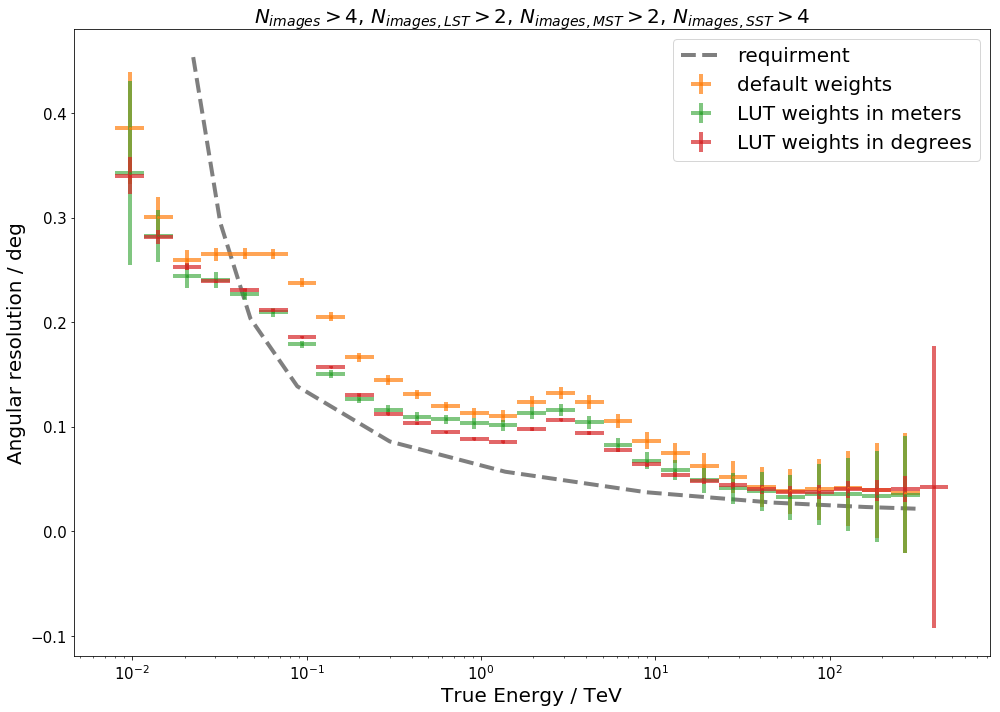

In [12]:
q_default_keep, pos, err_default_keep = calc_angular_resolution(off_angle=data_def_keep.off_angle,
                                  trueE=data_def_keep.MC_Energy, erange=[0.008, 700], bins=30)

q_default_remove, pos, err_default_remove = calc_angular_resolution(off_angle=data_def_remove.off_angle,
                                  trueE=data_def_remove.MC_Energy, erange=[0.008, 700], bins=30)

q_LUT_keep, pos, err_LUT_keep = calc_angular_resolution(off_angle=data_LUT_keep.off_angle,
                                  trueE=data_LUT_keep.MC_Energy, erange=[0.008, 700], bins=30)

q_LUT_remove, pos, err_LUT_remove = calc_angular_resolution(off_angle=data_LUT_remove.off_angle,
                                  trueE=data_LUT_remove.MC_Energy, erange=[0.008, 700], bins=30)

q_LUT_deg, pos, err_LUT_deg = calc_angular_resolution(off_angle=data_LUT_deg.off_angle,
                                  trueE=data_LUT_deg.MC_Energy, erange=[0.008, 700], bins=30)


plt.figure(figsize=(14,10))
rcParams['xtick.labelsize'] = 15
rcParams['ytick.labelsize'] = 15
plt.xscale('log')
#plt.ylim([0,.5])
plt.errorbar(pos, q_default_keep[0], q_default_keep[1], err_default_keep, fmt="o", color="C1", zorder=10,
             label="default weights", linewidth=4, markersize=2, alpha=0.7)
#plt.errorbar(pos, q_default_remove[0], q_default_remove[1], err_default_remove, fmt="o", color="C0", zorder=10,
#             label="default weights remove types ", linewidth=4, markersize=2, alpha=0.7)
plt.errorbar(pos, q_LUT_keep[0], q_LUT_keep[1], err_LUT_keep, fmt="o", color="C2", zorder=10,
             label="LUT weights in meters", linewidth=4, markersize=2, alpha=0.6)
#plt.errorbar(pos, q_LUT_remove[0], q_LUT_remove[1], err_LUT_remove, fmt="o", color="C3", zorder=10,
#             label="LUT, telescope types removed\n{:1.1e} events passed".format(len(data_LUT_remove)), linewidth=4, markersize=2, alpha=0.6)
plt.errorbar(pos, q_LUT_deg[0], q_LUT_deg[1], err_LUT_deg, fmt="o", color="C3", zorder=10,
             label="LUT weights in degrees", linewidth=4, markersize=2, alpha=0.7)
plt.plot(e, angres, linewidth=4, label="requirment", color="k", alpha=0.5, linestyle="--")
plt.xlabel("True Energy / TeV", fontsize=20)
plt.ylabel("Angular resolution / deg", fontsize=20)
plt.title(r"$N_{images}>4$, $N_{images, LST}>2$, $N_{images, MST}>2$, $N_{images, SST}>4$", fontsize=20)
plt.legend(fontsize=20)
plt.tight_layout()
plt.savefig("Standardarray_default_LUT_degrees_SST4.pdf")

In [ ]:
LUTgen = LookupGenerator.load("../../scripts/write_feature_list/ctapipe_aux_dir/direction_weights_LUT_all.json")
LUTgen.display_lookup(xlabel="size / pe", ylabel="width / length")

# Playground

## Analyze one file

# Ecample: make the LUT

In [12]:
source = event_source("/Users/konstantinpfrang/CTAPIPE/gamma_onSource/\
gamma_20deg_180deg_run1___cta-prod3_desert-2150m-Paranal-merged.simtel.gz",
                     max_events=10)

In [13]:
event = next(iter(source))
event.inst.subarray.tel[1].camera

CameraGeometry(cam_id='LSTCam', pix_type='hexagonal', npix=1855, cam_rot=0.0 deg, pix_rot=100.893 deg)

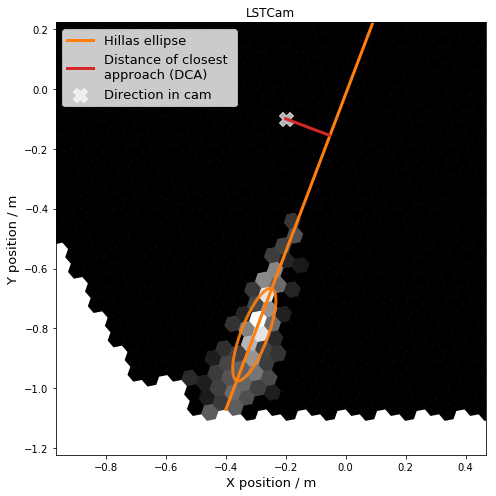

In [19]:
calibrator = CameraCalibrator(r1_product="HESSIOR1Calibrator")
for event in source:
    if event.count != 8:
        continue
    calibrator.calibrate(event)
    for tel in [11]:
        fig = plt.figure(figsize=[7,7])
        ax=fig.add_subplot(111)

        camera = event.inst.subarray.tel[tel].camera
        image = event.dl1.tel[tel].image[0]
        mask = tailcuts_clean(camera, image)
        image[~mask] = 0
        params = hillas_parameters(camera, image)
        
        disp = CameraDisplay(camera, image)
            
    direction_az = event.mc.az.to(u.deg)
    direction_alt = event.mc.alt.to(u.deg)
    cam_coord = LookupGenerator.get_position_in_cam(direction_alt, direction_az, event, tel)
    
    ax.scatter(-0.2, -0.1, label="Direction in cam", c="w", marker="X", s=200, alpha=0.7)
    disp.overlay_moments(params, color="C1", linewidth=3, with_label=False, alpha=0.9)
    
    def line(x, psi, x0, y0):
        m = np.tan(psi)
        return x * m - (-y0 + m * x0)
    
    x = np.linspace(-0.4, 0.3,1000)
    y = line(x, params.psi, params.x.value, params.y.value)
    x2 = np.linspace(-0.2, -0.055, 1000)
    y2 = line(x2, params.psi - np.pi * u.rad/2, -0.2, -0.1)
    
    ax.plot(x, y, color="C1", linewidth=3, label="Hillas ellipse")
    
    ax.plot(x2, y2, color="C3", linewidth=3, label="Distance of closest \napproach (DCA)")

    ax.set_xlim(-0.7, 0.2)
    ax.set_ylim(-1.2, 0.2)
    
    plt.xlabel("X position / m", fontsize=13)
    plt.ylabel("Y position / m", fontsize=13)
    plt.legend(fontsize=13)

    plt.tight_layout()
    plt.savefig("./Plots/DCA_calculation.pdf")

# Checking the dca calculation for a couple of telescopes

100%|██████████| 3/3 [00:00<00:00, 63.78it/s]


-0.5309340864575177 m 0.4033235040325491 m
-0.5309340864575177 m 0.4033235040325491 m


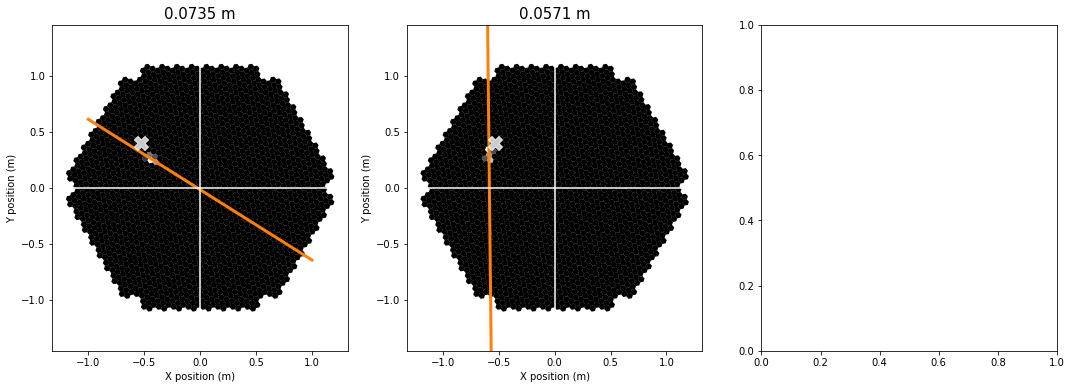

100%|██████████| 6/6 [00:00<00:00, 64.65it/s]


0.25106915029379523 m 0.512771593935105 m
0.25106915029379523 m 0.512771593935105 m
0.25106915029379523 m 0.512771593935105 m


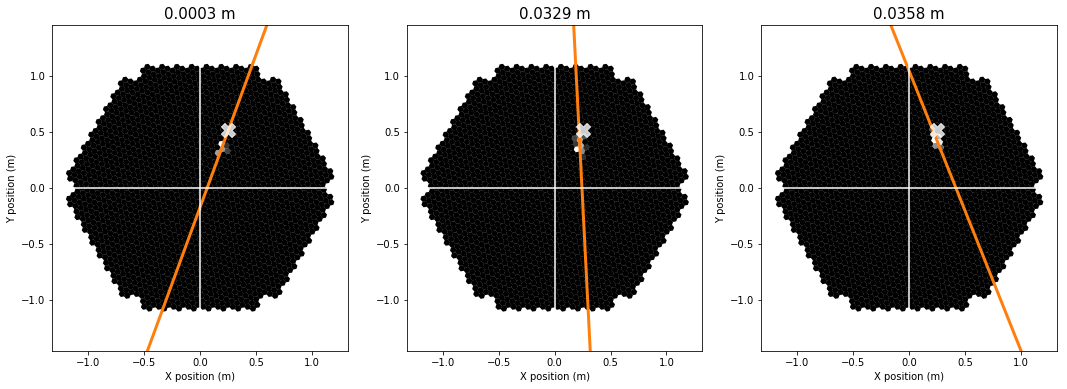

100%|██████████| 3/3 [00:00<00:00, 77.45it/s]


0.4703213175668023 m -0.4972383302426648 m
0.4703213175668023 m -0.4972383302426648 m


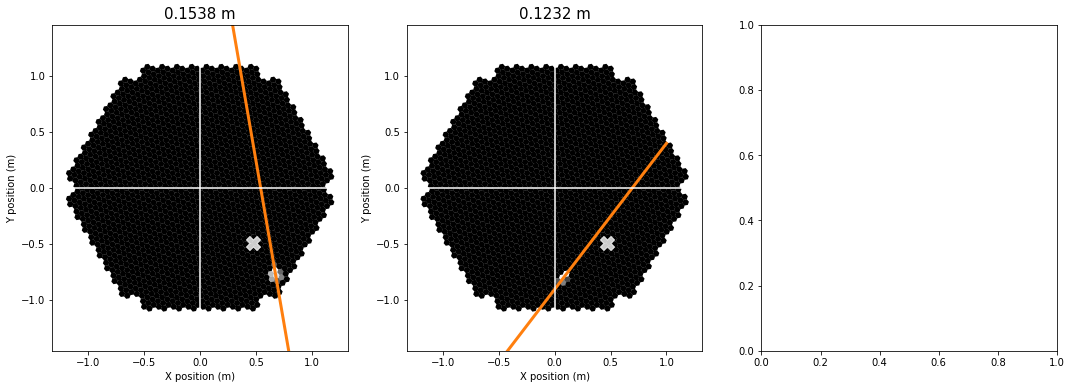

In [7]:
# diffuse
source = event_source("/Users/konstantinpfrang/CTAPIPE/gamma_cone/gamma_20deg_180deg_run1___cta-prod3_desert-2150m-Paranal-merged_cone10.simtel.gz",
                     max_events=3)

# point
#source = event_source("/Users/konstantinpfrang/CTAPIPE/gamma_onSource/\
#gamma_20deg_180deg_run1___cta-prod3_desert-2150m-Paranal-merged.simtel.gz",
#                     max_events=5)

tail_thresholds={
			"ASTRICam": [5, 7],
			"FlashCam": [12, 15],
			"LSTCam": [5, 10],
			"NectarCam": [4, 8],
			"DigiCam": [3, 6],
			"CHEC": [2, 4],
			"SCTCam": [1.5, 3]}

calibrator_cfg = Config()
calibrator_cfg["ChargeExtractorFactory"]["product"] = "LocalPeakIntegrator" # peak detection method
calibrator_cfg['WaveformCleanerFactory']['product'] = "NullWaveformCleaner" # waveform cleaning
calibrator_cfg["ChargeExtractorFactory"]["window_width"] = 7 # width of integration window
calibrator_cfg["ChargeExtractorFactory"]["window_shift"] = 3 # shift of integration window

calibrator = CameraCalibrator(r1_product="HESSIOR1Calibrator", config=calibrator_cfg)

# Thresholds for gain channel selection
pe_thresh = {
    "ASTRICam": 14,
    "LSTCam": 100,
    "NectarCam": 190}

lookupdata = {}
columns = ["dca", "length", "width", "intensity"]

hillas_dict = {}

LUTgen = LookupGenerator()
for event in source:
    hillas_dict = {}
    dca_dict = {}
    image_dict = {}
    camera_dict = {}
    cam_coord_dict = {}
    
    calibrator.calibrate(event)
    
    
    for tel_id in tqdm(event.r0.tels_with_data, total=len(list(event.r0.tels_with_data))):

        camera = event.inst.subarray.tel[tel_id].camera

        if camera.cam_id in pe_thresh.keys():
            image, mask = pick_gain_channel(event.dl1.tel[tel_id].image,
                      pe_thresh[camera.cam_id], select_by_sample=True)
        else:
            image = np.squeeze(event.dl1.tel[tel_id].image)

        mask = tailcuts_clean(camera, image=image,
                              min_number_picture_neighbors=2,
                              picture_thresh=tail_thresholds[camera.cam_id][1],
                              boundary_thresh=tail_thresholds[camera.cam_id][0])

        if sum(mask) == 0:
            continue
        cleaned_image = np.copy(image) # copy of image
        cleaned_image[~mask] = 0 # setting not survived pixels to zero

        params = hillas_parameters(camera, cleaned_image)
        
        direction_az = event.mc.az.to(u.deg)
        direction_alt = event.mc.alt.to(u.deg)  
        cam_coord = LookupGenerator.get_position_in_cam(direction_alt, direction_az, event, tel_id)
        
        dca = LUTgen.calculate_dca((cam_coord.x, cam_coord.y), params)
        hillas_dict[tel_id] = params
        dca_dict[tel_id] = dca
        image_dict[tel_id] = cleaned_image
        camera_dict[tel_id] = camera
        cam_coord_dict[tel_id] = cam_coord
        
    ncol = 3
    nrow = len(hillas_dict)//ncol + 1 * (len(hillas_dict)%ncol > 0)
    fs = 6
    fig, axes = plt.subplots(nrow, ncol, figsize=(fs*ncol, fs*nrow))
    for ii, tel_id in enumerate(hillas_dict):
        ax = axes.ravel()[ii]
        disp = CameraDisplay(camera_dict[tel_id], image_dict[tel_id], ax=ax,)

        def line(x, psi, x0, y0):
            m = np.tan(psi)
            return x * m - (-y0 + m * x0)
        ax.set_title("{:.4f}".format(dca_dict[tel_id]), fontsize=15)
        x = np.linspace(-1, 1,1000)
        y = line(x, hillas_dict[tel_id].psi, hillas_dict[tel_id].x.value, hillas_dict[tel_id].y.value)
        ax.plot(x,y, color='C1', linewidth=3)
        ax.set_ylim([-1.1, 1.1])
        
        print(cam_coord_dict[tel_id].x, cam_coord_dict[tel_id].y)
        ax.scatter(cam_coord_dict[tel_id].x.value, cam_coord_dict[tel_id].y.value,
                    marker="X", s=200, c="w", zorder=3, alpha=0.8)
        ax.axvline(0, color="w")
        ax.axhline(0, color="w")
    plt.show()

In [23]:
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10

# LUT for point like simulations

/Users/konstantinpfrang/anaconda3/envs/cta-dev/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


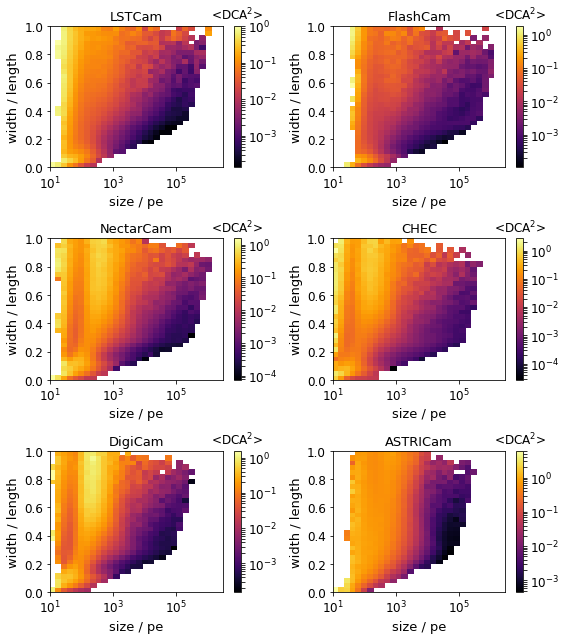

In [48]:
number_entries = len(LUTGen.lookup)
figsize = [8, 3 * number_entries / 2]
f, axarr = plt.subplots(int(number_entries / 2), 2, figsize=figsize)

rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12

cams = ["LSTCam", "FlashCam", "NectarCam", "CHEC", "DigiCam", "ASTRICam"]
for ii, cam in enumerate(cams):
    ax = axarr.ravel()[ii]

    dca = ax.pcolormesh(LUTGen.lookup[cam][1], LUTGen.lookup[cam][2],
                        LUTGen.lookup[cam][-1].T, norm=LogNorm(), cmap="inferno")
    
    ax.set_xlabel("size / pe", fontsize=13)
    ax.set_ylabel("width / length", fontsize=13)
    ax.set_xscale("log")
    ax.set_yscale("linear")
    clb = plt.colorbar(dca, ax=ax, norm=LogNorm())
    clb.ax.set_title("<DCA$^2$>", fontsize=12)
    ax.set_title(cam, fontsize=13)
plt.tight_layout()
plt.savefig("./Plots/LUT_pointlike.pdf")

# Diffuse LUT in different bins of offset angle

In [50]:
from konsta_cta.reco import DiffuseLUT

/Users/konstantinpfrang/anaconda3/envs/cta-dev/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


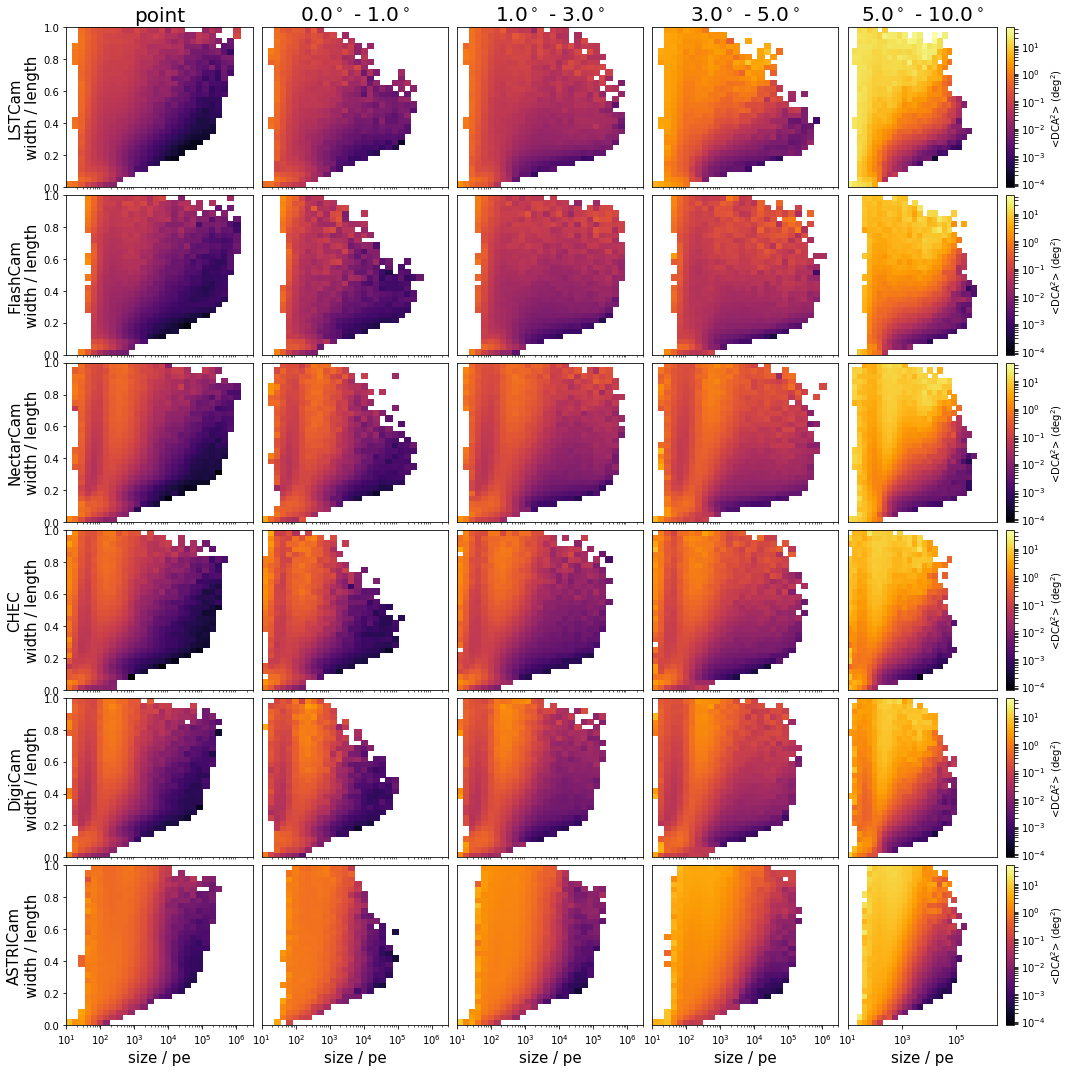

In [25]:
# load point
LUTGen = LookupGenerator.load("../../scripts/write_feature_list/ctapipe_aux_dir/direction_weights_LUT_point.json")

# load diffuse
file = "../../scripts/write_feature_list/ctapipe_aux_dir/direction_weights_LUT_diff1.json"
with open(file, "rb") as file:
    LUTdiff = pickle.load(file)

# append the two sets of LUT
LUTdiff["bins"].append("point")
LUTdiff[-1] = LUTGen.lookup

# plot with same z axis
max_val, min_val = get_vrange(LUTdiff, min_stat=5)
plot_verbose(LUTdiff, min_stat=5, colorbar=True, max_val=max_val, min_val=min_val)
plt.savefig("./Plots/LUTs_point_diffuse.pdf")

/Users/konstantinpfrang/anaconda3/envs/cta-dev/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


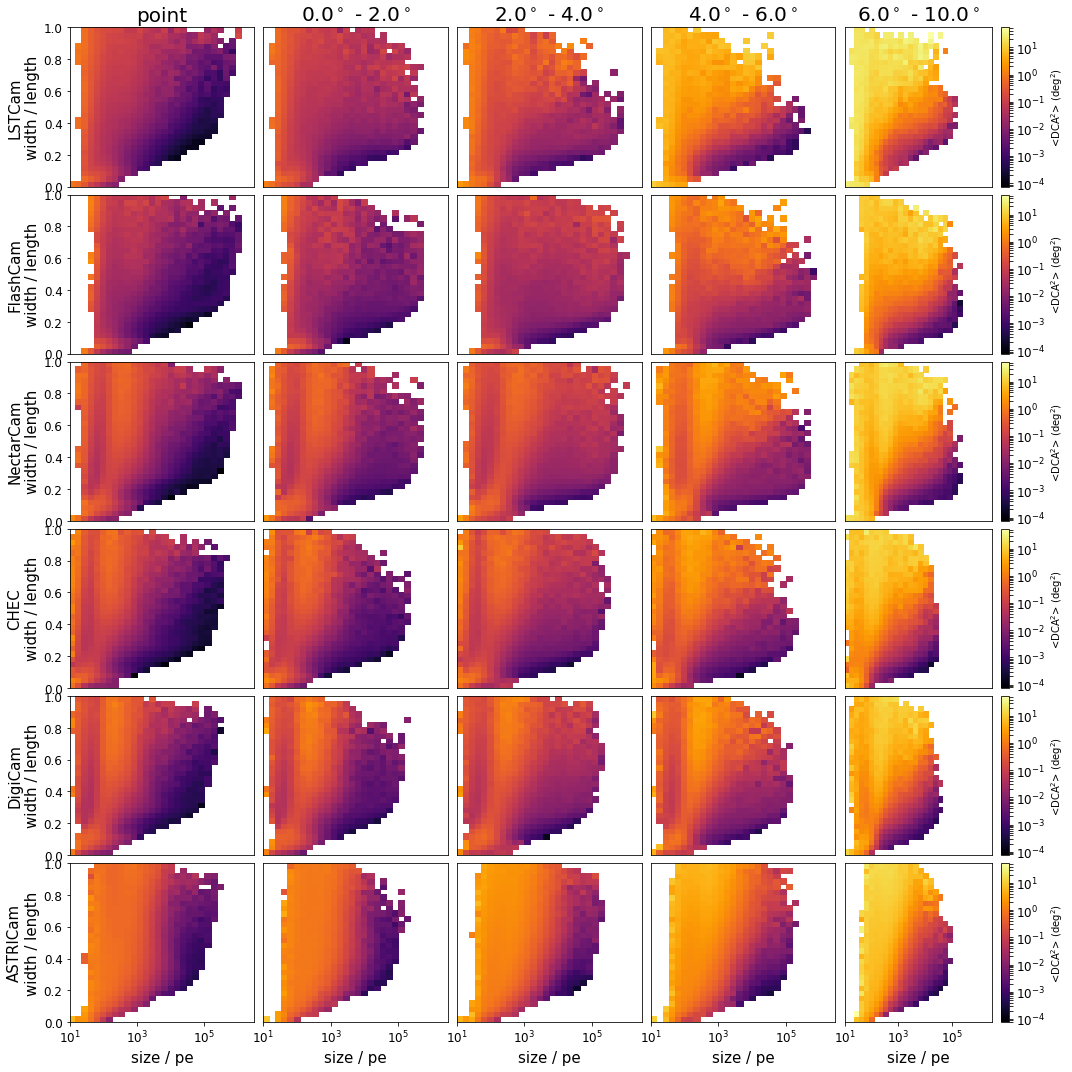

In [49]:
# load point
LUTGen = LookupGenerator.load("../../scripts/write_feature_list/ctapipe_aux_dir/direction_weights_LUT_point.json")

# load diffuse
file = "../../scripts/write_feature_list/ctapipe_aux_dir/direction_weights_LUT_diff.json"
with open(file, "rb") as file:
    LUTdiff = pickle.load(file)

# append the two sets of LUT
LUTdiff["bins"].append("point")
LUTdiff[-1] = LUTGen.lookup

# plot with same z axis
max_val, min_val = get_vrange(LUTdiff, min_stat=5)
plot_verbose(LUTdiff, min_stat=5, colorbar=True, max_val=max_val, min_val=min_val)
plt.savefig("./Plots/LUTs_point_diffuse.pdf")